In [1]:
%config InlineBackend.figure_format = 'retina'

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager
import matplotlib as mpl
import matplotlib.patches as mp
import seaborn as sns

# 设置全局字体
font_dirs = ['/public/home/mowp/test/fonts/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
import pandas as pd
import numpy as np

In [3]:
import sys
sys.path.append('/public1/mowp/workspace/mowp_scripts/tools/analysis')
%load_ext autoreload
%autoreload 1

In [4]:
%aimport plot

In [5]:
pal = plot.color_pal('set2')
sns.set_palette(pal)

In [6]:
import os

COLOR = {
    "HEADER": "\033[95m",
    "blue": "\033[94m",
    "green": "\033[92m",
    "red": "\033[91m",
    "ENDC": "\033[0m",
}

def shell_print(text, color='blue'):
    print(COLOR[color], text, COLOR["ENDC"])

<h1>Structural Variation Pipeline Tutorial</h1>

This tutorial provides an introduction to the detection and analysis of structural variation (SV) from Oxford Nanopore Technologies whole human genome sequencing experiments. The tutorial walks through and introduces the steps involved in SV detection, filtering and refinement. The workflow introduced uses a human reads dataset (`.fastq` file) as its starting point.

Computational requirements for this tutorial include:

* Computer running the EPI2ME Labs notebook Server
* At least 16Gb RAM

> ⚠️ Warning: This notebook has been saved with its outputs for demostration purposed. It is recommeded to select Edit > Clear all outputs before using the notebook to analyse your own data.

## Introduction

Long read DNA sequences, when mapped to a reference genome, can be used for the discovery and characterisation of structural variation. This is achieved by investigating discordant mapping where regions of a single sequenced DNA molecule map to different regions of the genome. Software packages such as [cuteSV](https://github.com/tjiangHIT/cuteSV) identify these discordant regions and can be used to call insertions, deletions, duplications, and more.

This tutorial is based on the Oxford Nanopore Technologies [wf-human-sv](https://github.com/epi2me-labs/wf-human-sv) software, which is an automated end-to-end workflow available on github. This analysis pipeline utilises the [cuteSV](https://github.com/tjiangHIT/cuteSV) software and may be used to identify high confidence genomic insertion and deletion events in Human datasets.

The tutorial is packaged with example data from the [Genome in a Bottle](https://www.nist.gov/programs-projects/genome-bottle) project ([GM24385](https://www.coriell.org/0/Sections/Search/Sample_Detail.aspx?Ref=GM24385&Product=CC)). The analysis considers a collection of sequence reads that map to a 50 Mb region from Chromosome 20.

The workflow covered in this tutorial will:

* Assess some whole genome human sequencing data in `.fastq` format in terms of read length and quality.
* Align our sequencing data to the reference genome using `LRA`.
* Assess the resulting `.bam` file for qualitative characteristics including mapping quality, number of mapped reads and depth-of-coverage.
* Identify a set of SVs relative to a human reference genome using `cuteSV`.
* Refine the SVs to produce a high quality subset in a `.vcf` format file.

The tutorial workflow will answer questions such as:

* How many sequence reads map to the reference genome?
* What is the depth of sequence coverage across the genome?
* How many SVs can be identified, what is their size distribution, and how frequent are the different types of SV?

## Getting started

The structural variation tutorial requires long read whole genome human sequencing data in `.fastq` format. An example dataset is provided with this workflow.

> Tip: To execute the commands click on the cell and then press Command/Ctrl-Enter, or click the Play symbol to the left-hand side. 

Before anything else we will create and set a working directory:

### Install additional software

*Please note that the software installed is not persistent and this step will need to be re-run if you stop and restart the EPI2ME Labs server*

In [ ]:
# Install additional packages via mamba (click play)
! mamba install lra cuteSV seqtk fastcat -yq

### Sample data

To demonstrate this structural variation workflow a small dataset is provided. This dataset corresponds to sequence reads from the GM12878 human reference material that map to the hg19 reference genome. To facilitate a quick analysis and speedy download the whole dataset has been downsampled to a 50 Mb region of chromosome 20.

The code below will download the sample `.fastq` reads, the reference genome in `.fasta` format and a tabular `.bed` file for targeted calling. The `wget` command is used to download the files.

In [ ]:
# Download sample data (click play)
import os

# download the data
location='s3://ont-exd-int-s3-euwst1-epi2me-labs/sv_tutorial'
s3_bucket = "ont-exd-int-s3-euwst1-epi2me-labs"
s3_prefix = "sv_tutorial/GM24385.nf7.chr20_af_minimap2.fastq.gz"
s3_reference = "sv_tutorial/chr20_human_g1k_v37.fasta.gz"
s3_bedfile = "sv_tutorial/target.bed"
s3_alignments = "sv_tutorial/GM24385.nf7.chr20_af_minimap2.bam"
reads = os.path.basename(s3_prefix)
bam = os.path.basename(s3_alignments)
reference = os.path.basename(s3_reference)
!echo "Downloading sample data"
!wget -c -O "$reads" https://"$s3_bucket".s3.amazonaws.com/"$s3_prefix"
!wget -c -O "$reference" https://"$s3_bucket".s3.amazonaws.com/"$s3_reference"
!wget -c -O "target.bed" https://"$s3_bucket".s3.amazonaws.com/"$s3_bedfile"
!wget -c -O "$bam"  https://"$s3_bucket".s3.amazonaws.com/"$s3_alignments"

### Using your own data

If you wish to analyse your own data rather than the sample data, you can edit the value `.fastq input` variable below. To find the correct full path of a directory you can navigate to it in
the `Files` browser to the left-hand side, right-click on the file and select `Copy path`:

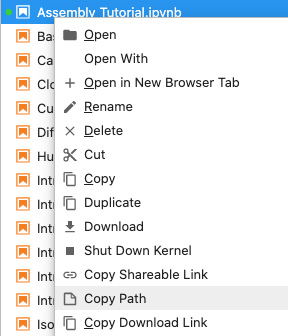

## Data input

Having downloaded the sample data, or locating your own data in the file browser, we need to provide the appropriate file locations as input to the notebook.

The main inputs are:

* `fastq` is the set of reads in `.fastq` format (gzip allowed).
* `reference` is the reference genome file in `.fasta` format (gzip allowed).
* `target_bed` is a `.bed` coordinate file that defines the genomic regions of interest. If you do not wish to filter by a region leave this field empty. See the appendix for more details.
* `threads` defines the number of compute threads that will be used by the processes that can multi-thread. Please do not use more threads than are available on your computer.

Finally, we can also tune the characteristics of the SV analysis using the following inputs:

* `min_sv_length` and `max_sv_length` defines the length of the shortest and longest allowable structural variations respectively.
* `min_read_length` sets the minimum length of reads to be considered when discovering SVs.
* `min_read_support` determines how many reads at minimum must be in support of a potential SV for it to be called.
* `mean_read_mapping_quality` sets the minimum average quality of reads to be considered when discovering SVs.

The form below can also be edited to reflect different values for the above options, but sensible defaults are provided. Ensure that you click the form `Enter` button to set the variables for the rest of the workflow.

### Inspecting input data (optional)

Prior to beginning the analysis proper, it is always prudent to inspect the data we are going to use in our workflow, specficically casting our eye over `read_lengths` and `quality scores`. We want to ascertain that these distributions look like we expect them to look, specifically that the read lengths are sufficient for SV calling (too short and the SV calling will be suboptimal) and that the quality of the reads is not significantly lower than expected (lower means there is likely to be higher error within the reads rate leading to a drop in call accuracy).

To perform these checks we will run `seqkit stats` and `fastcat` to generate a range of summary information, which can then be displayed in tabular format or plotted as distributions.

In [7]:
# Seqkit (optional)
threads = 48
fastq = 'GM24385.nf7.chr20_af_minimap2.fastq.gz'
read_stats = "reads.seqkit.tsv"

cmd = f"seqkit stats -T -a -b -j {threads} {fastq} > {read_stats}"

shell_print(cmd)

 seqkit stats -T -a -b -j 48 GM24385.nf7.chr20_af_minimap2.fastq.gz > reads.seqkit.tsv 


In [8]:
df_reads = pd.read_csv(read_stats, sep='\t')
df_reads

,file,format,type,num_seqs,sum_len,min_len,avg_len,max_len,Q1,Q2,Q3,sum_gap,N50,Q20(%),Q30(%)
0,GM24385.nf7.chr20_af_minimap2.fastq.gz,FASTQ,DNA,88893,1668011592,152,18764.3,302406,2563,6922,21750,0,52493,63.68,45.43


In [9]:
# Fastcat (optional)
per_read_stats = 'per_read_stats.txt'

cmd = f"fastcat --read {per_read_stats} {fastq} > /dev/null"

shell_print(cmd)

 fastcat --read per_read_stats.txt GM24385.nf7.chr20_af_minimap2.fastq.gz > /dev/null 


In [10]:
df_per_read = pd.read_csv(per_read_stats, sep='\t')[['read_id','filename','read_length','mean_quality']]
df_per_read

,read_id,filename,read_length,mean_quality
0,0175f4dc-e60a-45fc-9160-52120d6acdec,GM24385.nf7.chr20_af_minimap2.fastq.gz,109226,11.09
1,48e6444a-5b38-4d1e-923f-9c50db41db7c,GM24385.nf7.chr20_af_minimap2.fastq.gz,49387,12.76
2,2d34865e-10bc-4043-bbc7-267be5861b4e,GM24385.nf7.chr20_af_minimap2.fastq.gz,8513,12.37
3,a9176777-5819-4eee-b426-8b210557c013,GM24385.nf7.chr20_af_minimap2.fastq.gz,36824,9.81
4,9270a16f-1325-43bb-a9ab-8633a5240718,GM24385.nf7.chr20_af_minimap2.fastq.gz,83950,12.77
...,...,...,...,...
88888,642d8290-5c12-4163-a664-899118369142,GM24385.nf7.chr20_af_minimap2.fastq.gz,3575,12.11
88889,9fa3f9f4-592c-4e4f-ac5b-eb22f34a4f61,GM24385.nf7.chr20_af_minimap2.fastq.gz,3607,11.75
88890,7bbf4f92-13bc-468f-aab5-630aa27900e7,GM24385.nf7.chr20_af_minimap2.fastq.gz,4059,7.37
88891,ddca39ff-1527-4d3d-a42e-a1dac1ef955b,GM24385.nf7.chr20_af_minimap2.fastq.gz,30769,8.30


Mean: 18764.26
Medain: 6922.00


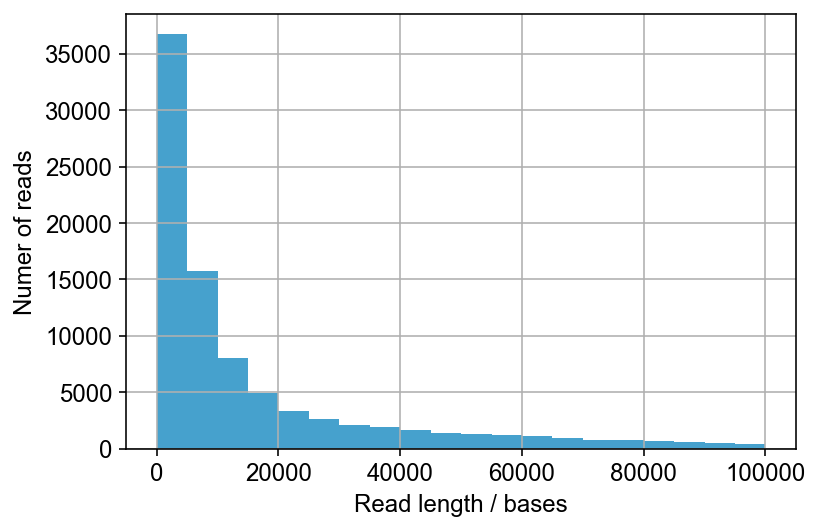

In [11]:
ax = df_per_read['read_length'].hist(bins=20, range=(0, 100_000))
ax.set_xlabel('Read length / bases')
ax.set_ylabel('Numer of reads')

print(f'Mean: {np.mean(df_per_read["read_length"]):.02f}')
print(f'Medain: {np.median(df_per_read["read_length"]):.02f}')

Mean: 10.57
Medain: 10.77


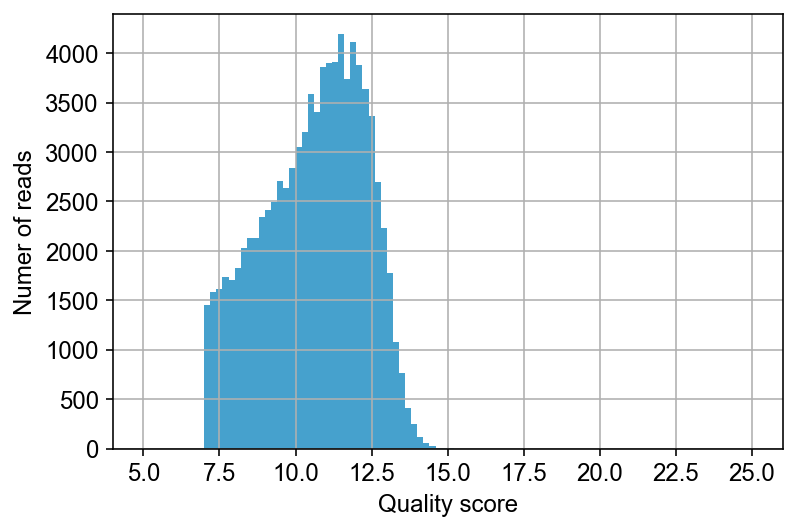

In [12]:
ax = df_per_read['mean_quality'].hist(bins=100, range=(5, 25))
ax.set_xlabel('Quality score')
ax.set_ylabel('Numer of reads')

print(f'Mean: {np.mean(df_per_read["mean_quality"]):.02f}')
print(f'Medain: {np.median(df_per_read["mean_quality"]):.02f}')

## Read Alignment

CuteSV is a reference alignment based SV caller, meaning the first step in using it to call SVs is to align the reads to the reference genome using an aligner such as Minimap2 or LRA. LRA is the aligner used in the wf-human-sv workflow because it has been determined to provide better results in the context of Human SV detection than minimap2, so we'll use the same approach here, although minimap2 is also a viable option.

When aligning reads to a reference, we tend to follow these steps:

- Index the reference genome
- Align the reads to the reference genome
- Sort and Index the output `.sam` file from alignment to create a `.bam` file

For a more complete understanding of what these terms mean, see the Introduction to SAM/BAM tutorial provided within EPI2ME Labs.

这个教程用使用的是lar进行比对，另外可以尝试使用 [Winnowmap](https://github.com/marbl/Winnowmap), 专门用于比对重复序列

In [13]:
# Align reads to reference genome using LRA. Creates .bam file (click play)

reference = 'chr20_human_g1k_v37.fasta.gz'
fastq = 'GM24385.nf7.chr20_af_minimap2.fastq.gz'
threads = 48
aligned_bam = 'aligned.bam'

cmd = f"""
    lra index -ONT {reference} \
    && seqtk seq -A {fastq} \
    | lra align -ONT -p s -t {threads} {reference} - \
    | samtools calmd -u - {reference} \
    | samtools sort -@ {threads} -o {aligned_bam} - \
    && samtools index -@ {threads} {aligned_bam}
""".strip('\n').replace('    ', '')
shell_print(cmd)

 lra index -ONT chr20_human_g1k_v37.fasta.gz && seqtk seq -A GM24385.nf7.chr20_af_minimap2.fastq.gz | lra align -ONT -p s -t 48 chr20_human_g1k_v37.fasta.gz - | samtools calmd -u - chr20_human_g1k_v37.fasta.gz | samtools sort -@ 48 -o aligned.bam - && samtools index -@ 48 aligned.bam 


### Mapping Analysis (optional)
Before calling structural variants in our dataset it is worthwhile to review the key quality characteristics from our `.bam`  file.

The `seqkit bam` method is used to prepare a collection of per read-alignment summary observations. These observations will be presented as figures and tables that describe the distribution of mapping qualities, depths of coverage and summarise the numbers of reads and sequence bases that map to the reference genome.

In [14]:
# Run seqkit bam to get alignment stats (click play)

aligned_bam = 'aligned.bam'
alignment_stats = 'alignments.seqkit.tsv'

cmd = f"seqkit bam {aligned_bam} 2> {alignment_stats}"
shell_print(cmd)

 seqkit bam aligned.bam 2> alignments.seqkit.tsv 


In [15]:
df = pd.read_csv(alignment_stats, sep='\t')[[
    'Read','Ref','Pos','EndPos','MapQual','Acc','ReadLen','RefAln',
    'RefCov','ReadAln','ReadCov','Strand','LeftClip','RightClip',
    'Flags','IsSec','IsSup']]
df.head()

,Read,Ref,Pos,EndPos,MapQual,Acc,ReadLen,RefAln,RefCov,ReadAln,ReadCov,Strand,LeftClip,RightClip,Flags,IsSec,IsSup
0,be97f83b-3d51-4779-8e2b-bc92a878174e,20,60001,64041,60,93.402,11785,4040,0.006,3940,33.432,-1,7805,40,16,0,0
1,53ab8f9f-4767-474c-bb37-85cdc87d2d0b,20,60001,90949,60,81.816,44454,30948,0.049,28407,63.902,-1,16006,41,16,0,0
2,2d34865e-10bc-4043-bbc7-267be5861b4e,20,60005,61073,60,92.216,8513,1068,0.002,1048,12.311,1,7445,20,0,0,0
3,a9176777-5819-4eee-b426-8b210557c013,20,60005,85933,60,87.272,36824,25928,0.041,25278,68.645,1,11540,6,0,0,0
4,2b5fb7bc-c545-439c-a818-1a229c2d5e02,20,60005,130667,60,91.335,72372,70662,0.112,68723,94.958,1,3617,32,0,0,0


Using the output from `seqkit` we can derive some basic statistics concerning the alignments of reads to the reference sequence:

In [16]:
def parse_seqkit(fname):
    cols = {
        'Read':str, 'MapQual':int, 'Acc':float, 'ReadLen':int,
        'ReadAln':int, 'ReadCov':float, 'IsSec':bool, 'IsSup':bool}
    df = pd.read_csv(fname, sep="\t", dtype=cols, usecols=cols.keys())
    df['Clipped'] = df['ReadLen'] - df['ReadAln']
    df['Type'] = 'Primary'
    df.loc[df['IsSec'], 'Type'] = 'Secondary'
    df.loc[df['IsSup'], 'Type'] = 'Supplementary'
    return df

def summarize_seqkit(df):
    grouped = df.groupby('Type').agg(**{
        'Alignments': ('Read', 'count'),
        'Unique Reads': ('Read', 'nunique'),
        'Ave. read length': ('ReadLen', 'median'),
        'Ave. mapping quality': ('MapQual', 'median'),
        'Ave. align length': ('ReadAln', 'median'),
        'Total aligned bases': ('ReadAln', 'sum'),
        'Total clipped bases': ('Clipped', 'sum')})
    for atype in ['Supplementary']:
        if atype not in df['Type'].values:
            atype_row = {
                'Alignments': 0,
                'Unique Reads': 0,
                'Ave. read length': 0,
                'Ave. mapping quality': 0,
                'Ave. align length': 0,
                'Total aligned bases': 0,
                'Total clipped bases': 0
            }
            grouped = grouped.append(pd.Series(atype_row, name=atype))
    grouped.loc[['Supplementary'], ['Ave. read length']] = "-"
    return grouped.transpose()

In [17]:
alignment_stats = 'alignments.seqkit.tsv'
seqkit_df = parse_seqkit(alignment_stats)
summary_table = summarize_seqkit(seqkit_df)
primarys = seqkit_df.loc[seqkit_df['Type'] == 'Primary']

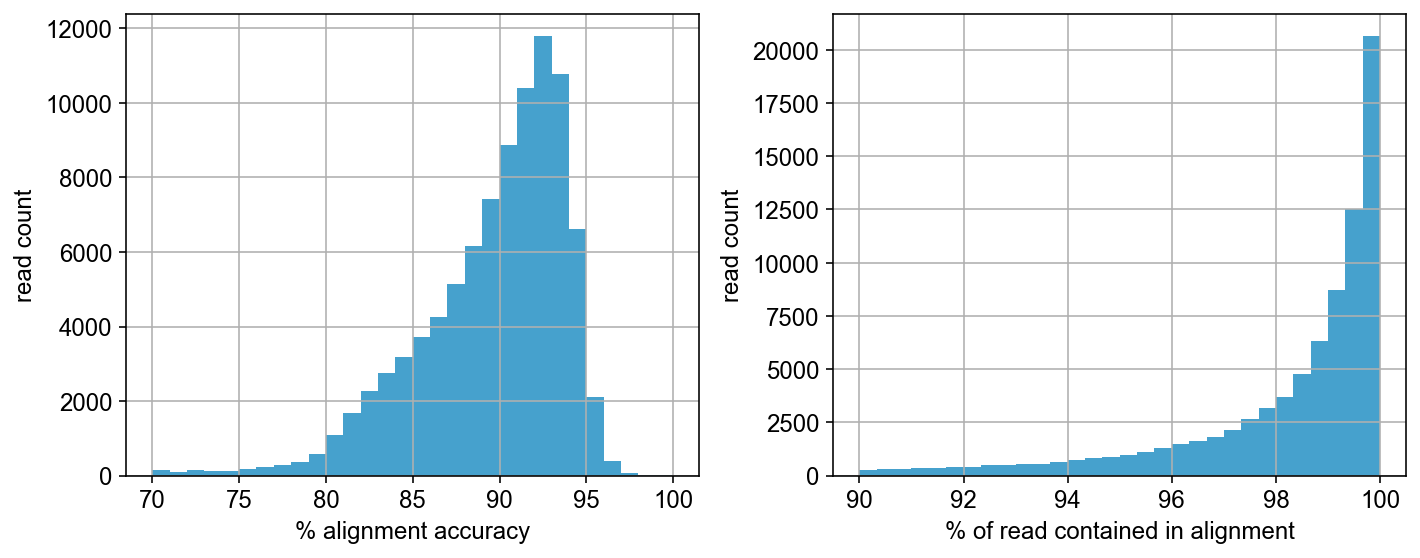

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

seqkit_df['Acc'].hist(bins=30, range=(70, 100), ax=ax[0])
ax[0].set_ylabel('read count')
ax[0].set_xlabel('% alignment accuracy')


seqkit_df['ReadCov'].hist(bins=30, range=(90, 100), ax=ax[1])
ax[1].set_ylabel('read count')
ax[1].set_xlabel('% of read contained in alignment')

plt.tight_layout()

In [19]:
summary_table

Type,Primary,Supplementary
Alignments,87780,4013
Unique Reads,87780,2695
Ave. read length,7069.0,-
Ave. mapping quality,60.0,60.0
Ave. align length,6774.0,5701.0
Total aligned bases,1576219368,65886357
Total clipped bases,90640547,166659280


## Calling Structural Variants

We will use `cuteSV` to call structural variants. In the code block below, `cuteSV` is called with parameters that define the acceptable size range for a call, minimum read length, minimum read support, and minimum mapping quality.

* `min_sv_length` is a minimum length threshold a call must have, which is set to 30 nucleotides by default.
* `max_sv_length` is a maximum length threshold above which we will not consider calls, set to 10000 by default.
* `min_read_length` is a minimum threshold for read lengths. This is used to reject the shortest mapping sequences and is by default defined as 1000 nucleotides.
* `read_support` is a minimum threshold for the number of required supporting reads. The default value requires that three of more reads cover an SV.
* `min_read_mapping_quality` was defined in the configuration form at the top of the analysis section (a value of 20 by default) and is a minimum threshold used to reject reads with lower quality mapping scores.

These parameters are permissive and will produce a large number of candidate SVs. This is intentional and subsequent steps in the workflow will qualitatively filter and refine the SV collection.

In [20]:
# Finding candidate variants with cuteSV (click play)

renamed = reference
if reference.endswith('.gz'):
    renamed = reference.split('.gz')[0]
    unzipper = f"bgzip -d -c {reference} > {renamed}"
    
min_sv_length = 30
max_sv_length = 1000000
min_read_length = 1000
min_read_mapping_quality = 20
min_read_support = 3
calls_vcf = 'calls.vcf'

cmd = f"""
    cuteSV \
        --threads {threads} \
        --genotype \
        -l {min_sv_length} \
        -L {max_sv_length} \
        -r {min_read_length} \
        -q {min_read_mapping_quality} \
        -s {min_read_support} \
        --max_cluster_bias_INS 100 \
        --diff_ratio_merging_INS 0.3 \
        --max_cluster_bias_DEL 100 \
        --diff_ratio_merging_DEL 0.3 \
        {aligned_bam} \
        {renamed} \
        {calls_vcf} .
""".strip('\n').replace('    ', '')

shell_print(cmd)

 cuteSV --threads 48 --genotype -l 30 -L 1000000 -r 1000 -q 20 -s 3 --max_cluster_bias_INS 100 --diff_ratio_merging_INS 0.3 --max_cluster_bias_DEL 100 --diff_ratio_merging_DEL 0.3 aligned.bam chr20_human_g1k_v37.fasta calls.vcf . 


### Filtering SVs by type, region, depth and frequency

The complete set of SVs from `cuteSV` can be filtered to regions of interest using the `.bed` file specified in the sections above, allowing for targeted downstream analysis.

To avoid false positive calls due to low read coverage we will now assess the read depth across the regions in the dataset using the `mosdepth` tool:

In [21]:
# Running mosdepth to calculate read coverage (click play)
target_bed = 'target.bed'
threads = 48

if target_bed != "":
    bed_opt = "-b {}".format(target_bed)
else:
    bed_opt = ""
cmd = f"mosdepth -n -x {bed_opt} -t {threads} depth {aligned_bam}"

shell_print(cmd)

 mosdepth -n -x -b target.bed -t 48 depth aligned.bam 


Using the average read depth we can compute a minimum read depth required to call variants. The code below first attempts to establish a bound using the average sequencing depth. If this lower that a minimum bound (`min_support`), then the higher value is chosen.

The original `.vcf` file produced by `cuteSV` can now be filtered by the depth threshold reported above, as well as by the region given with the regions bedfile, and by type of SV (insertions and deletions by default).

Ensure that you click the form `Enter` button on the form below to perform the filtering step.
 
 

In [23]:
# Run VCF filtering step (click play)
import pandas as pd
threshold_lookup = ['0'] + ['2'] * 10 + ['3'] * 9 + ['5'] * 20 + ['8'] * 100


def calculate_average_depth(path):
    """Get the average read depth."""    
    depth_table = pd.read_csv(
        path, 
        compression="gzip", 
        sep="\t", 
        header=None, 
        names=("chr", "start", "end", "avg_depth"))
    depth_table["length"] = depth_table["end"] - depth_table["start"]
    depth_table["sum_depth"] = depth_table["length"] * depth_table["avg_depth"]
    total_bases = sum(depth_table["length"])
    sum_depth = sum(depth_table["sum_depth"])
    avg_depth = sum_depth / total_bases
    
    return avg_depth


# Get SV type filters
sv_types = ['INS', 'DEL']

sv_type_filters = []
for svtype in sv_types:
    sv_type_filters.append(f'SVTYPE = \"{svtype}\"')
filter_sv_types = f"( {(' || ').join(sv_type_filters)} )"

# Get length filters
filter_min_len = f'ABS(SVLEN) >= {min_sv_length}'
filter_max_len = f'ABS(SVLEN) <= {max_sv_length}'

# Get min read support filter
depth_bedfile = 'depth.regions.bed.gz'
avg_depth = calculate_average_depth(depth_bedfile)
avg_depth = min(avg_depth, len(threshold_lookup) - 1)
detected_read_support = int(threshold_lookup[round(avg_depth)])

read_support = min_read_support
if detected_read_support > min_read_support:
    read_support = detected_read_support

filter_min_read_support = f'INFO/RE >= {read_support}'

# Build filter string
filters = [
    filter_sv_types,
    filter_min_len,
    filter_max_len,
    filter_min_read_support
]
filter_string = f"-i '{' && '.join(filters)}'"

# Add target_bed filter (optional)
if target_bed != "":
    filter_string = f"-T {target_bed} " + filter_string

# Print command to stdout
filtered_vcf = "filtered.vcf"
cmd = f"bcftools view {filter_string} {calls_vcf} > {filtered_vcf}"
shell_print(cmd)


 bcftools view -T target.bed -i '( SVTYPE = "INS" || SVTYPE = "DEL" ) && ABS(SVLEN) >= 30 && ABS(SVLEN) <= 1000000 && INFO/RE >= 5' calls.vcf > filtered.vcf 


In [24]:
# Run VCF sort and indexing step (click play)

sorted_filtered_vcf = "sorted.filtered.vcf"
sorted_filtered_vcf_gz = "sorted.filtered.vcf.gz"

cmd = f"bcftools sort {filtered_vcf} > {sorted_filtered_vcf}"
shell_print(cmd)

cmd = f"bgzip -f {sorted_filtered_vcf} && bcftools index {sorted_filtered_vcf_gz}"
shell_print(cmd)

 bcftools sort filtered.vcf > sorted.filtered.vcf 
 bgzip -f sorted.filtered.vcf && bcftools index sorted.filtered.vcf.gz 


## Analysis

In this section we will analyse the called and filtered variants. There are many more interesting things which can be learnt from the variant calls, including specific biological questions of interest. Here however we focus on simple, generic properties of the discovered variants.

To start we can generate plots indicating the occurence and density of SVs throughout the genome:

In [25]:
# Plotting SV density karyograms (click play)
def parse_vcf(fname):
    header = "CHROM POS ID REF ALT QUAL FILTER INFO FORMAT GT".split()
    vcf = pd.read_csv(fname, delimiter='\t', comment='#', names=header, dtype={'CHROM':str})
    #print(vcf.head())
    # The INFO field isn't quite a table, so this is cumbersome
    info = vcf['INFO'].str.split(pat=";",expand=True, n=1)
    vcf['STATUS'] = info[0]
    vcf['details'] = info[1].str.split(";").apply(lambda x: dict([y.split("=") for y in x]))
    for field in ['SVTYPE', 'SVLEN']:
        vcf[field] = vcf['details'].apply(lambda x: x[field])
    # filter to chromosome
    allowed = [str(x) for x in range(1,23)] + ['X','Y']
    vcf = vcf.loc[vcf['CHROM'].isin(allowed)]
    for orig, rename in (('INS', 'Insertion'), ('DEL', 'Deletion')):
        vcf.loc[vcf['SVTYPE'] == orig, 'SVTYPE'] = rename
    vcf['SVLEN'] = vcf['SVLEN'].astype(int)
    return vcf


sorted_filtered_vcf_gz = 'sorted.filtered.vcf.gz'
vcf = parse_vcf(sorted_filtered_vcf_gz)

In [26]:
# load genome size
from collections import defaultdict

infile = '/data/Zhaijx/mowp/db/hg38/dna_chr/hg38.chr.fasta.size'
genome_size = {}
exclude_chrom = {'Pt', 'Mt'}
with open(infile, 'r') as f:
    for line in f:
        line = line.strip().split('\t')
        if line[0] not in exclude_chrom:
            genome_size[line[0].replace('chr', '')] = int(line[1])

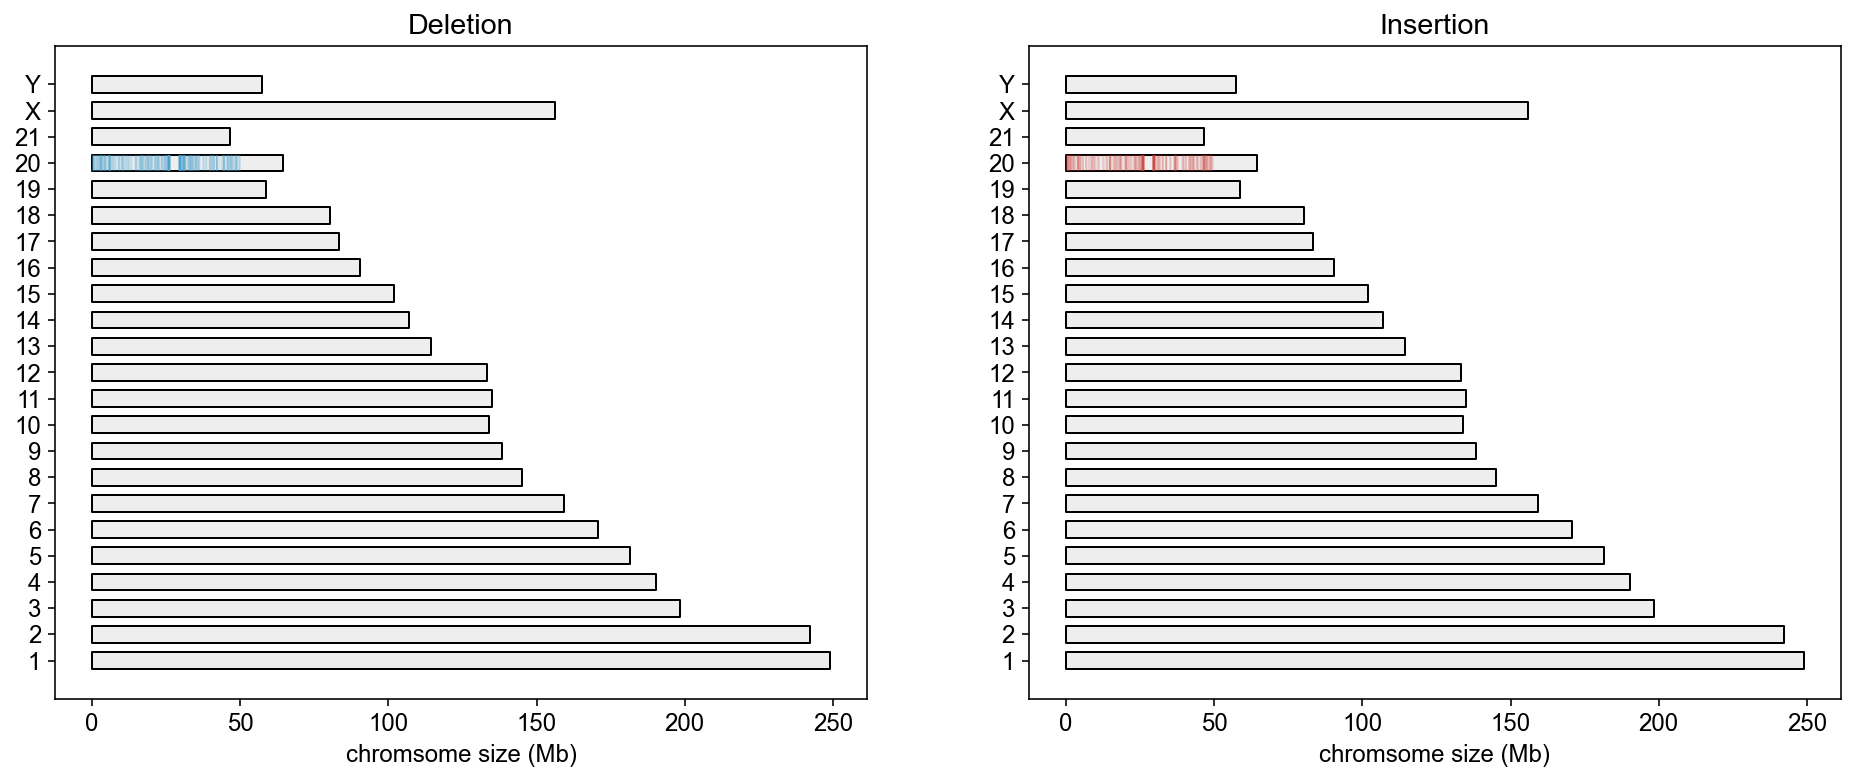

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
i = 0
for sv_types, marker_color in zip(('Deletion', 'Insertion'), pal):
    temp = vcf.loc[vcf['SVTYPE'] == sv_types]
    data = defaultdict(lambda: [])
    for item in temp.itertuples():
        data[item.CHROM].append((item.POS, 1))

    plot.karyotype(data, genome_size, marker_color=marker_color,
                   formatter='M', spacing=.5, ax=ax[i], figsize=(8, 6), marker_linewidth=.1)
    ax[i].set_title(sv_types)
    i += 1

For a more quantitative view of the data, let us examine the length distributions of the called variants separated by type:

In [28]:
vcf_summary = vcf.groupby('SVTYPE').agg(**{
        'Count': ('POS', 'count'),
        'Min. Length': ('SVLEN', lambda x: np.min(x.abs())),
        'Ave. Length': ('SVLEN', lambda x: np.median(x.abs())),
        'Max. Length': ('SVLEN', lambda x: np.max(x.abs()))}).transpose()

vcf_summary

SVTYPE,Deletion,Insertion
Count,407.0,286.0
Min. Length,30.0,30.0
Ave. Length,41.0,151.0
Max. Length,140015.0,11299.0


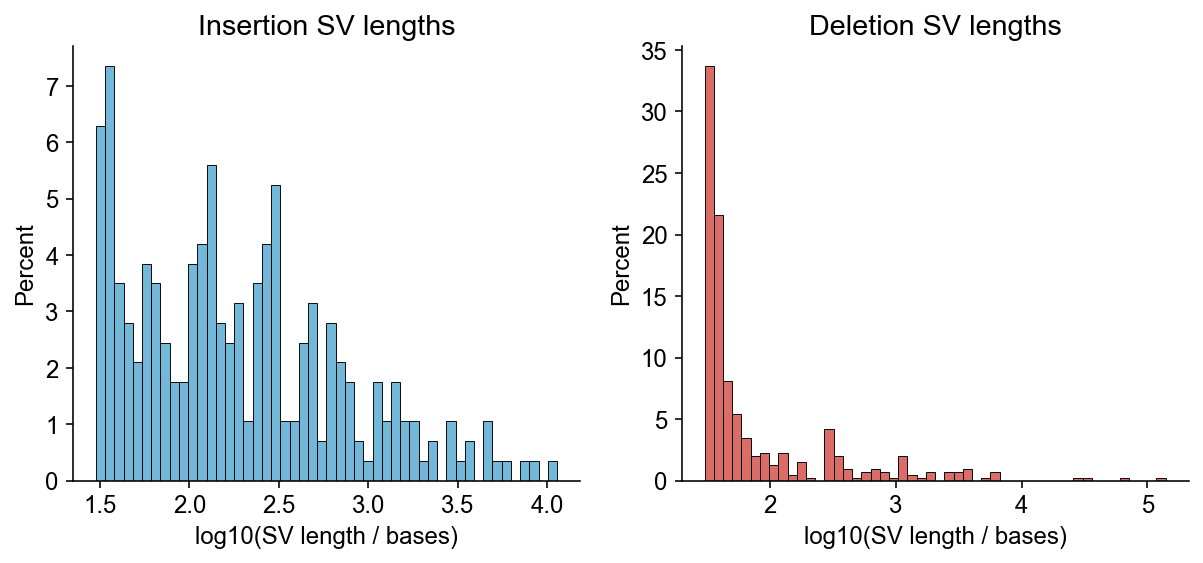

In [30]:
sv_types = ('Insertion', 'Deletion')

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
for i, (sv, color) in enumerate(zip(sv_types, pal)):
    data = np.log10(vcf.loc[vcf['SVTYPE'] == sv, 'SVLEN'].abs())
    sns.histplot(data, bins=50, ax=ax[i], color=color, stat='percent')
    ax[i].set_xlabel('log10(SV length / bases)')
    ax[i].set_title(f'{sv} SV lengths')
    plot.despine(ax[i])

## Summary

This tutorial has stepped through the calling an summary analysis of structural variants implied by an Oxford Nanopore long read dataset. Using the `cuteSV` package to call variants the types, lengths, and location of variants has been explored.

The analysis presented can also be run on any `.bam` alignment file generated by `lra` which retains supplementary alignments.


## Appendix 

**Example code for the preparation of a bed file**

In the workflow form at the head of this tutorial a requirement for a BED coordinate file was introduced. An appropriate `.bed` file may be prepared from a `.fasta` format reference genome with the following command.

```
$ pip install pyfaidx  
$ faidx --transform bed test.fasta > test.bed
```